### Quickstart Function Interface: Making custom Functions.

To benchmark, or train, new Optimization Algorithms on a diverse set of optimization scenarios, we provide tools to create new functions in a convenient manner. The simplest way to create new functions, is to compose a base functions with wrappers that extend its complexity. In our interface this can be done by specifying a base `Function` type and wrapping this with `FunctionWrapper` types. This notebook illustrates how one can leverage our API to create such functions through an explicit `haiku.Transformed` function or through our utilities.

In [12]:
import jax
import haiku as hk

from bbox import functions as fx
from bbox import wrappers as wx


@hk.transform
def my_fun(inputs: jax.Array) -> jax.Array:
    # Implement a noisy Ellipsoid function with an affine input transformation.
    f = fx.real.Ellipsoid() 

    f = wx.real.Translation(f, x_shift=2.0, y_shift=0.0)
    f = wx.real.UniformRotation(f)
    f = wx.real.WhiteNoise(f, stddev=0.1)
    
    # Evaluate f before calling f.register_optimum to initialize parameters.
    out = f(inputs)
    if hk.running_init():
        f.register_optimum(inputs)
        
    return out


key = jax.random.PRNGKey(123)
key_init, key_apply = jax.random.split(key)

x = jax.random.uniform(key, (2,))
params = my_fun.init(key_init, x)
y = my_fun.apply(params, key_apply, x)

print(x, y)
# >> [0.4878348  0.68895483] 3.9737816

[0.4878348  0.68895483] 3.9737816


The function parameters are managed by the `dm-haiku` API in a `hk.Params` container. This provides a set of common utilities to merge, partition, or transform specific parameters. It is also useful for defining specific levels of namespaces through `hk.lift` when defining sub-modules.

In [13]:
params

{'UniformRotation': {'rotation_matrix': Array([[-0.7400718, -0.6725279],
         [-0.6725279,  0.7400718]], dtype=float32)},
 'Translation': {'x_shift': Array([2., 2.], dtype=float32),
  'y_shift': Array(0., dtype=float32)},
 'Ellipsoid': {'exp_base': Array(0.5, dtype=float32)},
 'WhiteNoise': {'optimum_location': Array([ 2.8251994 , -0.13508773], dtype=float32),
  'optimum_value': Array(0.03263927, dtype=float32)}}

We also provide some utilities to parse the parameter containers of the functions to, e.g., retrieve the analytical optima (if available). As an example, we can see that the registered optimal value is the expected value over random keys at the optimal argument:

In [14]:
from bbox import get_param
from bbox.types import Parameter

x_opt = get_param(params, Parameter.OPTIMUM_LOCATION)
y_opt = get_param(params, Parameter.OPTIMUM_VALUE)

# Batch evaluate function across random-keys using jax.vmap
y_avg = jax.vmap(lambda k: my_fun.apply(params, k, x_opt))(
    jax.random.split(key, num=100)).mean()

print(x_opt, y_opt, y_avg)
# >> [0.03312814 2.8282332 ] 0.012413587 0.012142903

[ 2.8251994  -0.13508773] 0.032639273 0.015270544


For clarity we maintain a fixed alphabet of parameters to store and register keys within the `haiku.Params` container. All the default implementations in `bbox` define `haiku` parameters or state indexed by keys from `bbox.Parameter`.

In [4]:
list(filter(str.isupper, dir(Parameter)))

['AMPLITUDE',
 'BASES',
 'COVARIANCE_FACTOR',
 'EXPONENT',
 'EXP_BASE',
 'EXP_FACTOR',
 'NUM_BASES',
 'OPTIMUM_LOCATION',
 'OPTIMUM_VALUE',
 'PERIOD',
 'ROTATION_MATRIX',
 'SCALE',
 'SHIFT',
 'X_SCALE',
 'X_SHIFT',
 'Y_SCALE',
 'Y_SHIFT']

#### Example Evaluation over grid

We can conveniently evaluate our defined function over a 2D grid through `jax.numpy` and `jax.vmap` as the `dm-haiku` transformed function is automatically compatible with the `jax` module. This also goes for evaluating gradients if our designed function is indeed differentiable.

In [12]:
import matplotlib.pyplot as plt

from jax import numpy as jnp


x = y = jnp.linspace(-5, 5, 100)
XY = jnp.asarray(jnp.meshgrid(x, y)).reshape(2, -1).T

key_array = jax.random.split(key, num=len(XY))

out = jax.vmap(my_fun.apply, in_axes=(None, 0, 0))(params, key_array, XY)

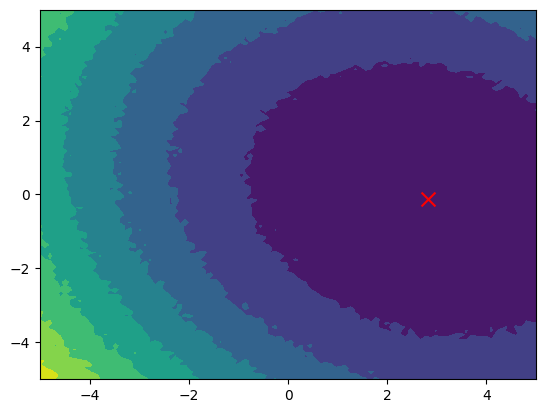

In [13]:
%matplotlib inline

plt.contourf(x, y, out.reshape(100, 100))
plt.scatter(x_opt[0], x_opt[1], marker='x', color='red', s=100)

### Function Creation Utilities

In the case that we have many wrappers, the explicit definition of new `Function` types can become rather verbose. Most commonly, we will want to create functions with one base function that is wrapped to add more complexity. This is not a restriction, as `Function` may also output arbitrary pytrees as transformations of its inputs. But in the simplest case of wrapping base `Function` types, we provide the `as_callable` and `as_transformed` utilities.

The utility `as_callable` transforms our defined function as a direct input-output mapping and absorbs the parameter container (and optionally the `None` PRNGKey) within the returned object. The `as_transformed` utility performs a sequential reduction of all provided `FunctionWrapper`s with the base `Function`, this requires the user to instantiate a `Partial` instance of 
the given base function and the wrappers if they are parameter dependent. This can be done either through `Function.partial` or `functools.partial`, by using the `Function.partial` method one can create a partially instantiated class, which may be useful to intermittenly lookup class attributes.

In [7]:
from bbox import as_callable, as_transformed


my_callable = as_callable(
    base=fx.real.Ellipsoid,
    wrappers=[
        wx.real.Translation.partial(x_shift=2.0, y_shift=0.0),
        wx.real.UniformRotation,
        wx.real.WhiteNoise.partial(stddev=0.1)
    ],
    rng=key_init,
    dummy_x=jnp.zeros(2)
)

In [8]:
# Parameters can still be accessed through function closure!
my_callable.__closure__[1].cell_contents

({'UniformRotation': {'rotation_matrix': Array([[-0.7400718, -0.6725279],
          [-0.6725279,  0.7400718]], dtype=float32)},
  'PartialTranslation': {'x_shift': Array([2., 2.], dtype=float32),
   'y_shift': Array(0., dtype=float32)},
  'Ellipsoid': {'exp_base': Array(0.5, dtype=float32)}},)

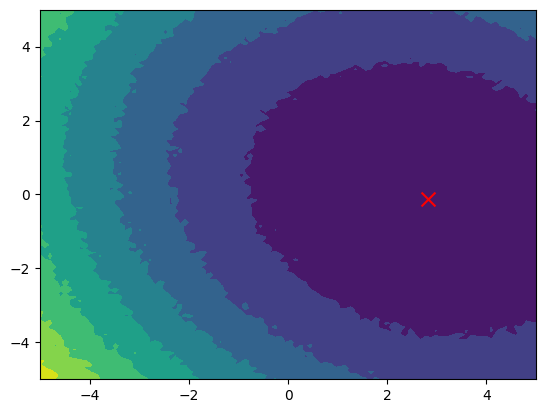

In [9]:
%matplotlib inline

out = jax.vmap(my_callable)(key_array, XY)

plt.contourf(x, y, out.reshape(100, 100))
plt.scatter(x_opt[0], x_opt[1], marker='x', color='red', s=100)  # This is now wrong.

By utilizing `as_transformed` we essentially get back the exact same function as the one we defined explicitly in the top of this notebook.

In [10]:
my_fun = as_transformed(
    base=fx.real.Ellipsoid,
    wrappers=[
        wx.real.Translation.partial(x_shift=2.0, y_shift=0.0),
        wx.real.UniformRotation,
        wx.real.WhiteNoise.partial(stddev=0.1)
    ],  
    register_optimum=True
)

In [11]:
### Copied from first notebook cell : Output is the same

key = jax.random.PRNGKey(123)
key_init, key_apply = jax.random.split(key)

x = jax.random.uniform(key, (2,))
params = my_fun.init(key_init, x)
y = my_fun.apply(params, key_apply, x)

print(x, y)
# >> [0.4878348  0.68895483] 3.0206795

[0.4878348  0.68895483] 3.9737816
